In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import cv2

from oiffile import OifFile

In [2]:
class OifImageViewer:
    
    # Channel 0: NG2+ cells
    # Channel 1: CD144 (blood vessel)
    
    def __init__(self, oif: OifFile) -> None:
        self.arr = oif.asarray()
        self.img_shape = self.arr.shape[2:]
        self.figsize = (25,25)
        print(self.__str__())
        
    def get_image(self, ch=0, z=0, beta=255) -> np.ndarray:
        return self.normalize(self.arr[ch][z], beta=beta)

    def show_image(self, ch=0, z=0, color=-1) -> None:
        plt.figure(figsize=self.figsize)
        norm_image = self.get_image(ch=ch, z=z)
        if color > -1:
            color_image = np.zeros((*self.img_shape, 3), dtype=np.uint16)
            color_image[:,:,color] = norm_image
            plt.imshow(color_image)
            return
        plt.imshow(self.BGR2RGB(norm_image))
        
    def combined_image(self, z=0) -> None:
        plt.figure(figsize=self.figsize)
        color_image = np.zeros((*self.img_shape, 3), dtype=np.uint16)
        for n_ch, arr_ch in enumerate(self.arr):
            color_image[:,:,n_ch] = self.normalize(arr_ch[z])
        plt.imshow(color_image)
        
    @staticmethod
    def normalize(image, beta=255):
        # 0-255 for uint8
        # 0-65535 for uint16
        return cv2.normalize(
            image, 
            dst=None, 
            alpha=0, 
            beta=beta, 
            norm_type=cv2.NORM_MINMAX
        )
    
    @staticmethod
    def BGR2RGB(image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    def __str__(self):
        return (
            f"Image shape: {self.arr.shape}\n"
            "Axes: CZYX\n"
            f"Dtype: {self.arr.dtype}\n"
        )

In [3]:
path = "../../data/New_Bone_Project/788_Export_05202022/788_Bone_1_Side_1.oif"

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)
#     viewer.combined_image(z=40)


Image shape: (2, 80, 4247, 7508)
Axes: CZYX
Dtype: uint16



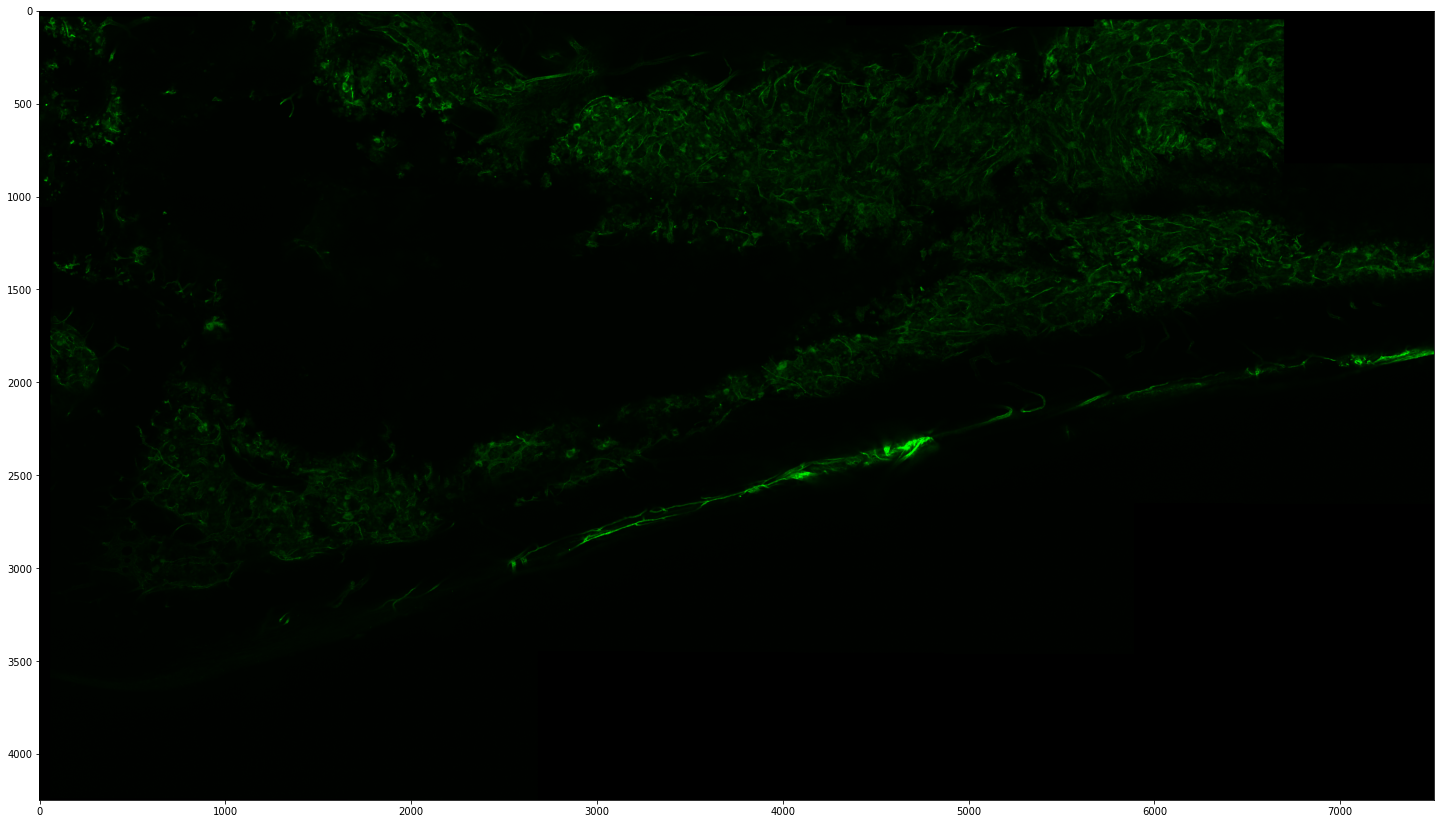

In [4]:
viewer.show_image(ch=1, z=40, color=1)
image = viewer.get_image(ch=1, z=40)

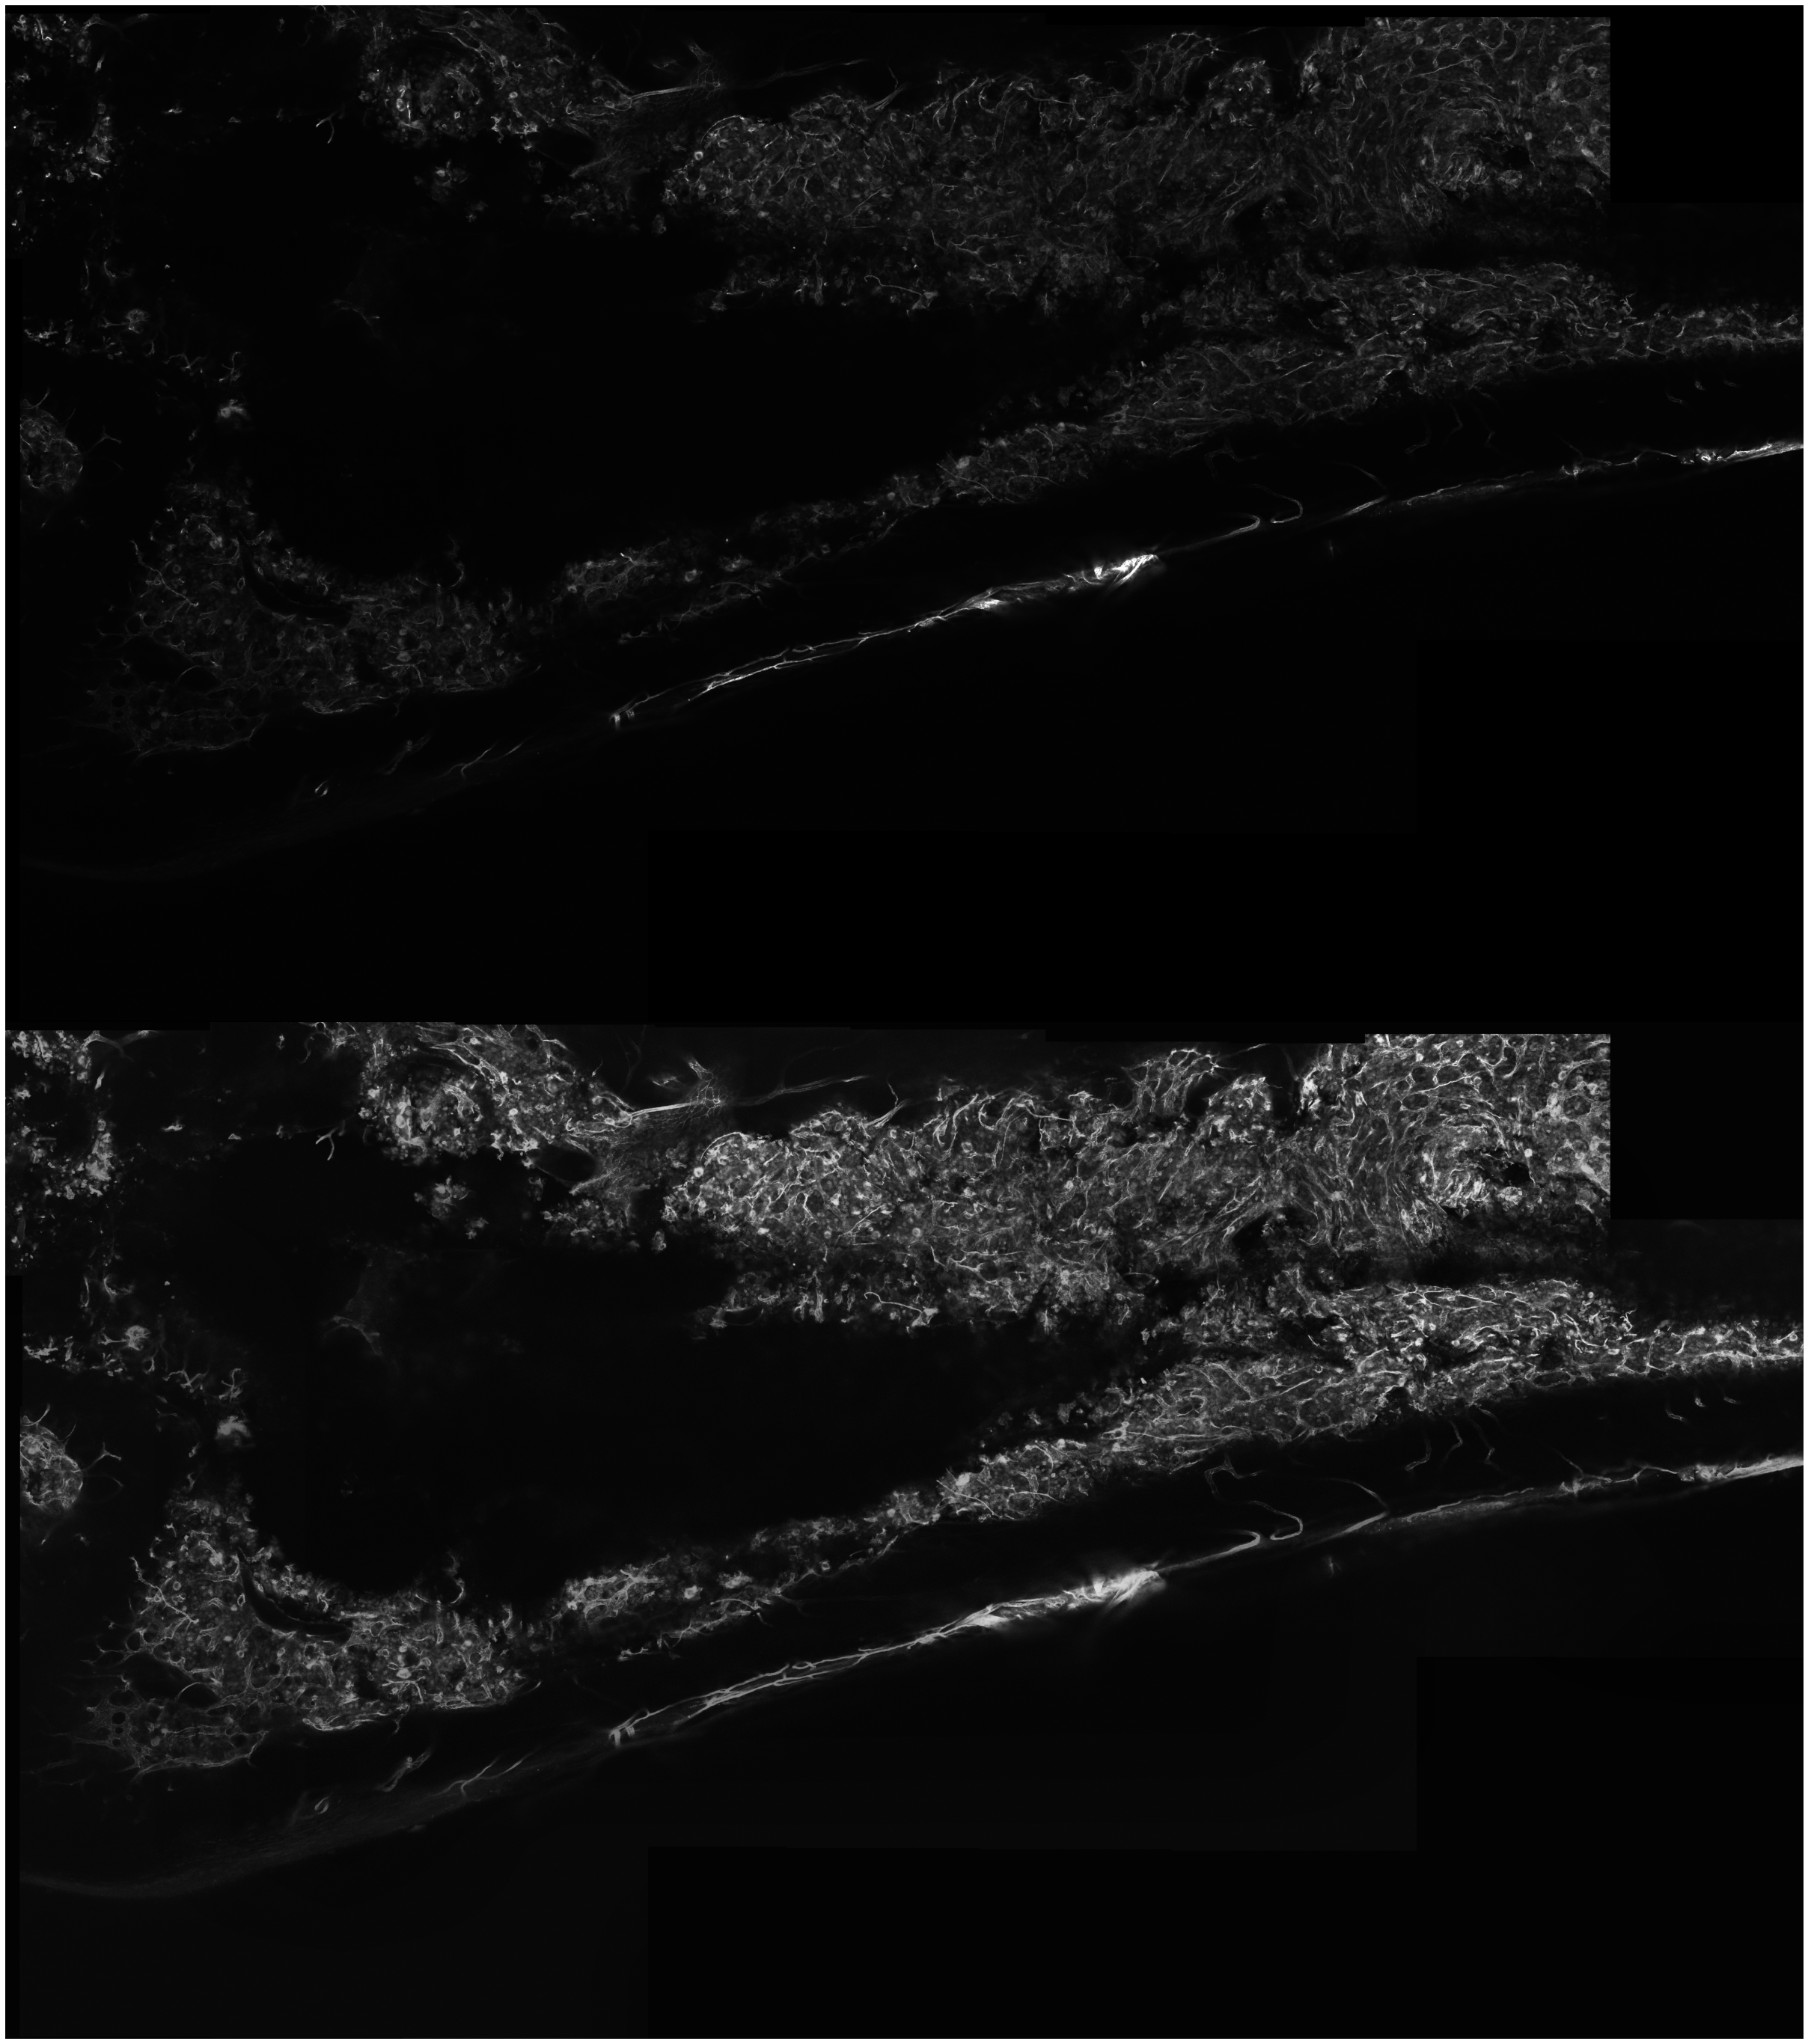

In [5]:
equalized_image = cv2.equalizeHist(np.uint8(image))

clahe = cv2.createCLAHE(clipLimit=100.0, tileGridSize=(8,8))
clahe_image = viewer.normalize(clahe.apply(image))

imgs = [
    image,
#     equalized_image,
    clahe_image
]

f, ax = plt.subplots(len(imgs), 1, figsize=(50,50))
for i, a in enumerate(ax):
    a.set_axis_off()
    a.imshow(viewer.BGR2RGB(imgs[i]))

f.subplots_adjust(wspace=0, hspace=0)

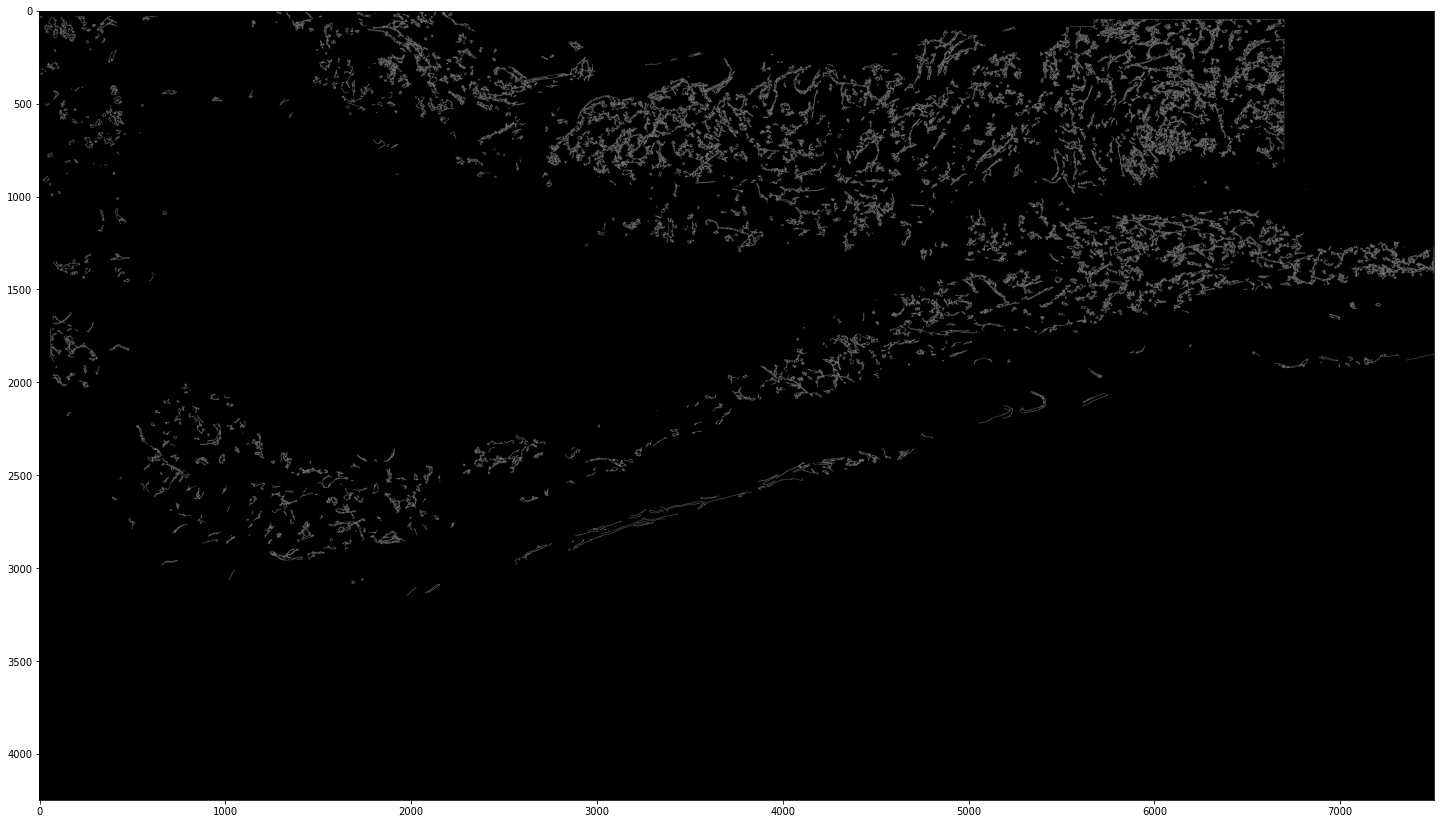

In [53]:
canny_image = cv2.Canny(np.uint8(clahe_image), 100, 400, apertureSize=3)
plt.figure(figsize=(25,25))
plt.imshow(viewer.BGR2RGB(viewer.normalize(canny_image)))

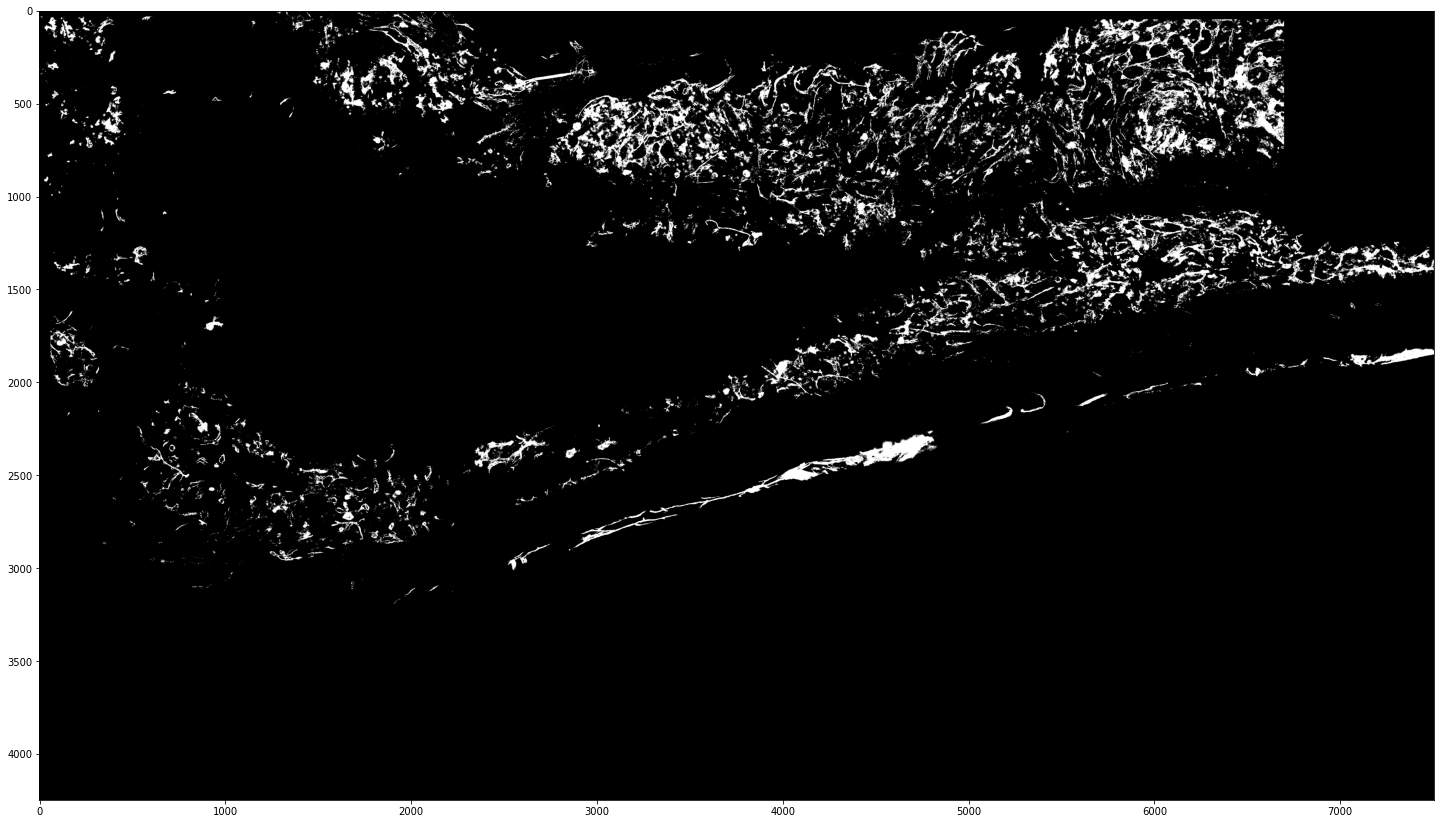

In [61]:
# blurredimage = cv2.GaussianBlur(clahe_image, (5,5), 0)
_, threshold_image = cv2.threshold(clahe_image, 90, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(25,25))
plt.imshow(viewer.BGR2RGB(viewer.normalize(threshold_image)))